## Combinbing Images

Create pseudo foveated mongrels by combining mongrels at different eccentricities

In [1]:
# read in 3 mongrels
import cv2
import matplotlib.pyplot as plt
import numpy as np

base_directory = './60_olap_sweep'
image_number = 139
eccentricities = [0,50,100,150,200,250,300,450]

image_name = str(image_number).zfill(12)

./coco_test/000000000139.jpg


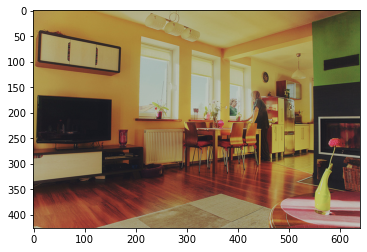

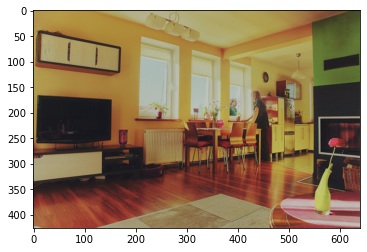

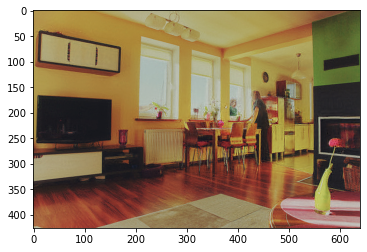

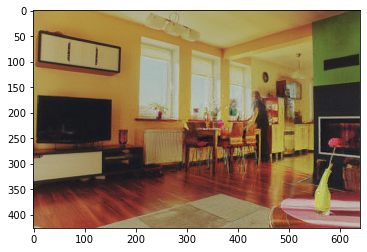

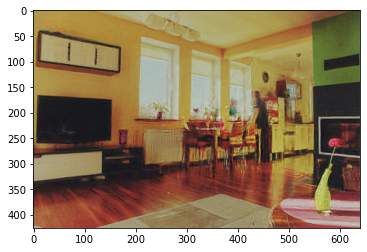

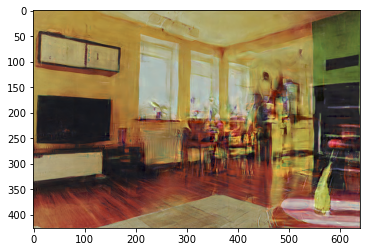

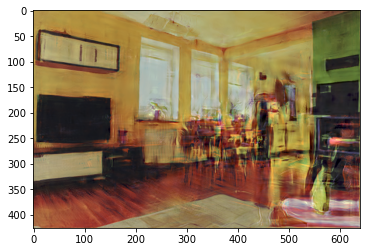

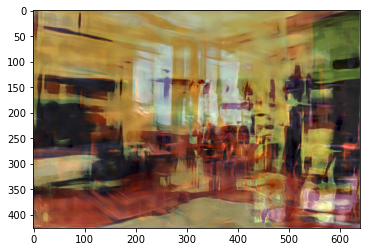

In [180]:
def readin_mongrels(eccentricities_list, image_name, base_directory, showims=False):
    imgs = []
    
    #original image
    original_fname = f'./coco_test/{image_name}.jpg'
    print(original_fname)
    ori_img = cv2.imread(original_fname)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    imgs.append(ori_img)
    if(showims):
        plt.imshow(ori_img)
        plt.show()
    
    #eccentricities
    for e in eccentricities_list[1:]:
        mongrel_fname = f'{base_directory}/{image_name}_X{e}_YNaN_2022-08-12_uniform_60olap_{e}/mongrelized_{image_name}_uniform_60olap_{e}.png'
        mong = cv2.imread(mongrel_fname)
        mong = cv2.cvtColor(mong, cv2.COLOR_BGR2RGB)
        imgs.append(mong)
        #print(mong)
        
        if(showims):
            plt.imshow(mong)
            plt.show()
    return(imgs)

mongs = readin_mongrels(eccentricities, image_name, base_directory, showims=True)

In [181]:
mongrel_vector = np.random.rand(5,500,500,3)
foveation_location = (320,240)
pad = 300
mongrel_vector.shape
foveation_location = (foveation_location[0] + pad//2,foveation_location[1] + pad//2)
fovea_size = 16

img_shape = np.shape(mongrel_vector[0])

y, x = np.indices([img_shape[0]+pad, img_shape[1]+pad])
num_bins = np.min([img_shape[0]+pad, img_shape[1]+pad])

normalized = ((x-foveation_location[0]),(y-foveation_location[1]))
r = np.hypot(normalized[0], normalized[1])

normalized
#plt.imshow(r)
#plt.colorbar()

img_shape[0]+150

650

(700, 500) (670, 563)


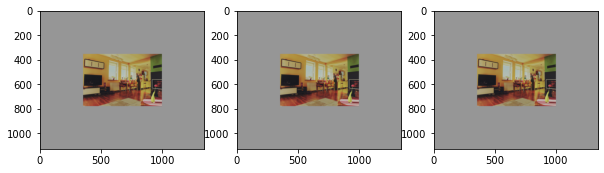

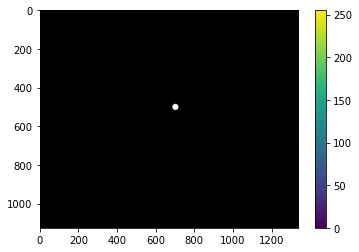

(700, 500) (670, 563)


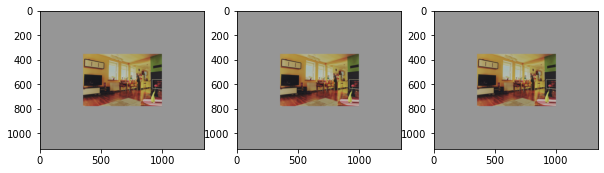

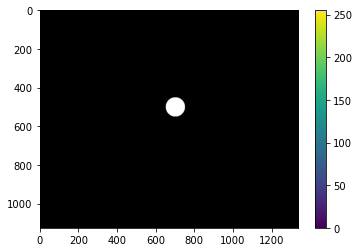

(700, 500) (670, 563)


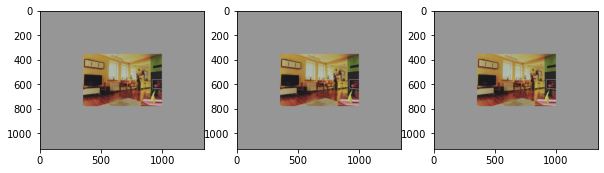

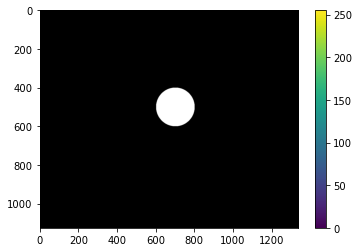

(700, 500) (670, 563)


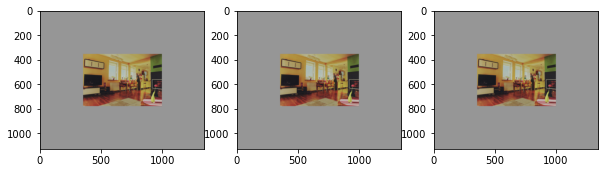

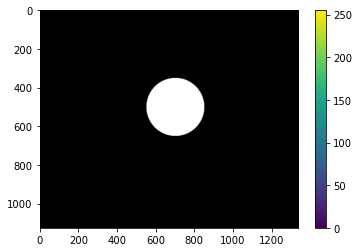

(700, 500) (670, 563)


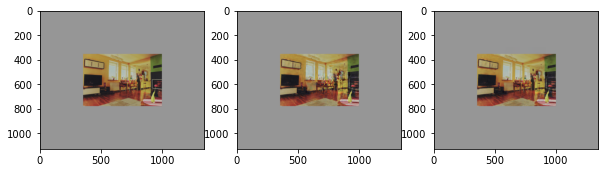

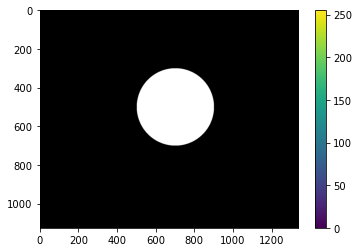

(700, 500) (670, 563)


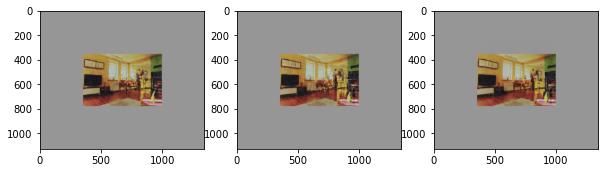

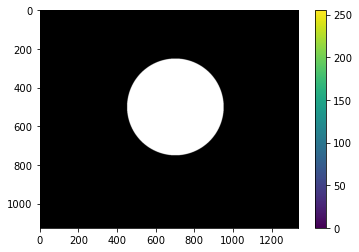

(700, 500) (670, 563)


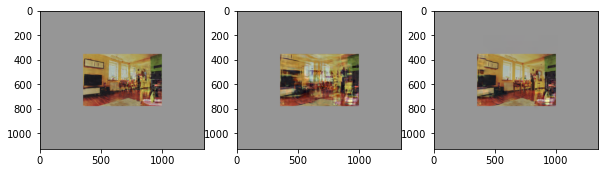

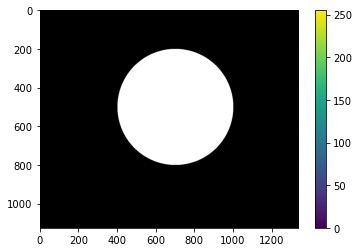

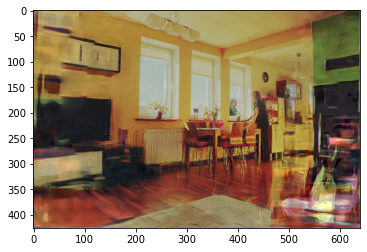

In [187]:
def create_psuedo_foveated_img_poisson(mongrel_vector,ecc_list, foveation_location,debug_plotting=False):
    pad = 700
    foveation_location = (foveation_location[0] + pad//2,foveation_location[1] + pad//2)
    fovea_size = 16

    img_shape = np.shape(mongrel_vector[0])
    
    y, x = np.indices([img_shape[0]+pad, img_shape[1]+pad])
    num_bins = np.min([img_shape[0]+pad, img_shape[1]+pad])

    normalized = ((x-foveation_location[0]),(y-foveation_location[1]))
    r = np.hypot(normalized[0], normalized[1])

    #pseudo_foveated = np.zeros_like(mongrel_vector[0])
    mongrel_slices = []
    ecc_mask_3d_list = []
    for i, ecc in enumerate(ecc_list[:-1]):
        #if i == len(ecc_list)-1:
        #    break
        if(i==0):
            min_ecc = 0
            max_ecc = fovea_size
        #elif i== len(ecc_list)-2:
        #    min_ecc = 0
        #    max_ecc = ecc_list[i]
        else:
            min_ecc = ecc_list[0]
            max_ecc = ecc_list[i] 

        ecc_mask = np.where((r>=min_ecc) & (r<max_ecc), True, False) == True
        ecc_mask_3d = np.concatenate((ecc_mask[:,:,None],ecc_mask[:,:,None],ecc_mask[:,:,None]),2)*255
        ecc_mask_3d_list.append(ecc_mask_3d.astype(mongrel_vector[i].dtype))
        
        source = 150*np.ones((img_shape[0]+pad,img_shape[1]+pad,img_shape[2]), mongrel_vector[0].dtype)
        dest = 150*np.ones((img_shape[0]+pad,img_shape[1]+pad,img_shape[2]), mongrel_vector[0].dtype)
        
        yoff = pad//2
        xoff = pad//2
        source[yoff:yoff+img_shape[0], xoff:xoff+img_shape[1]] = mongrel_vector[i]
        dest[yoff:yoff+img_shape[0], xoff:xoff+img_shape[1]] = mongrel_vector[i+1]
        
        img_center_pad = ((img_shape[1]+pad)//2, (img_shape[0]+pad)//2)
        print(foveation_location, img_center_pad)
        
        if i ==0:
            output = cv2.seamlessClone(source,dest,ecc_mask_3d.astype(mongrel_vector[0].dtype),foveation_location,cv2.NORMAL_CLONE)
            #output = cv2.seamlessClone(source,dest,ecc_mask_3d.astype(mongrel_vector[0].dtype),img_center_pad,cv2.NORMAL_CLONE)
        # elif i ==len(ecc_list)-2:
        #     # plt.imshow(output)
        #     # plt.show()
        #     # plt.imshow(dest)
        #     # plt.show()
        #     output = cv2.seamlessClone(output,dest,ecc_mask_3d.astype(mongrel_vector[0].dtype),foveation_location,cv2.NORMAL_CLONE)
        #     #output = cv2.seamlessClone(output,dest,ecc_mask_3d.astype(mongrel_vector[0].dtype),img_center_pad,cv2.NORMAL_CLONE)
        else:
            output = cv2.seamlessClone(output,dest,ecc_mask_3d.astype(mongrel_vector[0].dtype),foveation_location,cv2.NORMAL_CLONE)
            #output = cv2.seamlessClone(source,output,ecc_mask_3d.astype(mongrel_vector[0].dtype),img_center_pad,cv2.NORMAL_CLONE)

        if(debug_plotting):
            plt.figure(figsize=(10,10))
            plt.subplot(1,3,1)
            plt.imshow(source)
            plt.subplot(1,3,2)
            plt.imshow(dest)
            plt.subplot(1,3,3)
            plt.imshow(output)
            plt.show()
            plt.imshow(1*ecc_mask_3d)
            plt.colorbar()
            plt.show()
    
    
    return output[yoff:yoff+img_shape[0], xoff:xoff+img_shape[1]]

#psuedo_foveated_mongrel = create_psuedo_foveated_img_poisson(mongs,eccentricities[:],(100,100))
psuedo_foveated_mongrel = create_psuedo_foveated_img_poisson(mongs,eccentricities[:],(350,150),debug_plotting=True)
#psuedo_foveated_mongrel = create_psuedo_foveated_img_poisson(mongs,eccentricities[:-1],(320,240))
plt.imshow(psuedo_foveated_mongrel)
plt.savefig('testpsuudofoveation.png',dpi=300)


In [154]:
mk.dtype, mongs[0].dtype

(dtype('int64'), dtype('uint8'))

In [174]:
# src = mongs[0]
# #src = np.zeros((926,1140,3)).astype(np.uint8)
# dst = np.zeros_like(src)

# #mk = np.zeros(src.shape,src.dtype)
# mk = mk.astype(src.dtype)
# #mk = mk+255
# #poly = np.array([ [4,80], [30,54], [151,63], [254,37], [600,90], [272,400], [43,122] ], np.int32)
# #cv2.fillPoly(mk, [poly], (255, 255, 255))


# p = (np.shape(dst)[1]//2, np.shape(dst)[0]//2)
# result = cv2.seamlessClone(src, dst, mk, p, cv2.NORMAL_CLONE)

# #plt.figure('Name','Mixed Cloning')
# plt.figure(figsize=(10,10))
# plt.subplot(221), plt.imshow(src),plt.title('source')
# plt.subplot(222), plt.imshow(dst), plt.title('destination')
# plt.subplot(223), plt.imshow(mk), plt.title('mask')
# plt.subplot(224), plt.imshow(result), plt.title('cloned')
# # print(a.shape,b.shape,mk.shape)
# # plt.imshow(mk.astype(a.dtype))
# # plt.show()
# # plt.imshow(a)
# # plt.show()
# # plt.imshow(b)
# # plt.show()
# # o = cv2.seamlessClone(a,b,mk.astype(a.dtype),(500,500),cv2.NORMAL_CLONE)
# # plt.imshow(o)
# # plt.show()

In [104]:
mk.shape

(926, 1140, 3)

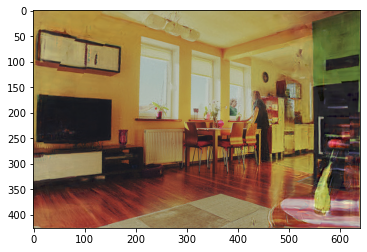

In [4]:
def create_psuedo_foveated_img(mongrel_vector):
    
    foveation_location = (320,240)
    fovea_size = 16

    img_shape = np.shape(mongrel_vector[0])

    # Calculate the indices from the image
    y, x = np.indices(img_shape[:-1])
    num_bins = np.min(img_shape[:-1])

    normalized = ((x-foveation_location[0]),(y-foveation_location[1]))
    r = np.hypot(normalized[0], normalized[1])

    pseudo_foveated = np.zeros_like(mongrel_vector[0])

    for i, ecc in enumerate(eccentricities):
        if(i==0):
            min_ecc = 0
            max_ecc = fovea_size
        # elif(i==1):
        #     min_ecc = fovea_size
        #     max_ecc = eccentricities[i]
        else:
            min_ecc = eccentricities[i-1]
            max_ecc = eccentricities[i]

        #print(i,ecc, min_ecc, max_ecc)

        #don't calculate corners
        ecc_mask = np.where((r>=min_ecc) & (r<max_ecc), True, False)

#         debugging
#         plt.imshow(r)
#         plt.colorbar()
#         plt.show()

#         plt.imshow(1*ecc_mask)
#         plt.colorbar()
#         plt.show()

        pseudo_foveated[ecc_mask,:] = mongrel_vector[i-1][ecc_mask,:]
    
    return(pseudo_foveated)

psuedo_foveated_mongrel = create_psuedo_foveated_img(mongs)
plt.imshow(psuedo_foveated_mongrel)

./coco_test/000000000552.jpg
(700, 500) (670, 563)
(700, 500) (670, 563)
(700, 500) (670, 563)
(700, 500) (670, 563)
(700, 500) (670, 563)
(700, 500) (670, 563)
(700, 500) (670, 563)


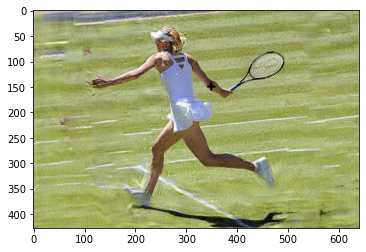

./coco_test/000000000205.jpg
(700, 500) (670, 590)
(700, 500) (670, 590)
(700, 500) (670, 590)
(700, 500) (670, 590)
(700, 500) (670, 590)
(700, 500) (670, 590)
(700, 500) (670, 590)


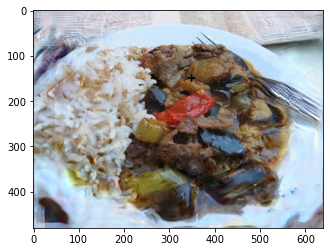

./coco_test/000000000139.jpg
(700, 500) (670, 563)
(700, 500) (670, 563)
(700, 500) (670, 563)
(700, 500) (670, 563)
(700, 500) (670, 563)
(700, 500) (670, 563)
(700, 500) (670, 563)


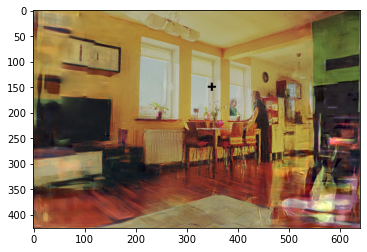

In [188]:
# with poisson, the mongrels looks better without 450 px
image_num_list =  [552,205,139]
for image_number in image_num_list:
    image_name = str(image_number).zfill(12)
    
    mongs = readin_mongrels(eccentricities, image_name, base_directory)
    x = 350
    y = 150
    psuedo_foveated_mongrel = create_psuedo_foveated_img_poisson(mongs,eccentricities,(x,y))
    with_fixation = np.copy(psuedo_foveated_mongrel)
    with_fixation[y-8:y+8,x-2:x+2,:] = 0
    with_fixation[y-2:y+2,x-8:x+8,:] = 0
    plt.imshow(psuedo_foveated_mongrel)
    plt.imshow(with_fixation)
    plt.show()
    psuedo_foveated_mongrel = cv2.cvtColor(psuedo_foveated_mongrel, cv2.COLOR_RGB2BGR)
    with_fixation = cv2.cvtColor(with_fixation, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'./pseudo_foveated_poisson/pseudo_foveated_fix_{x}_{y}_{image_name}.png',psuedo_foveated_mongrel)
    cv2.imwrite(f'./pseudo_foveated_poisson/pseudo_foveated_fix_{x}_{y}_{image_name}_with_fixation.png',with_fixation)

./coco_test/000000000019.jpg


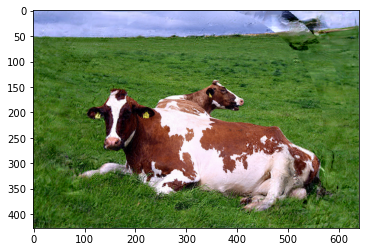

./coco_test/000000000069.jpg


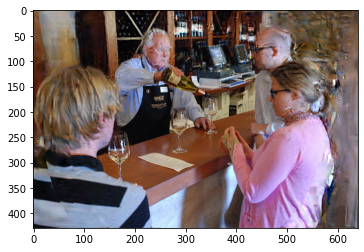

./coco_test/000000000979.jpg


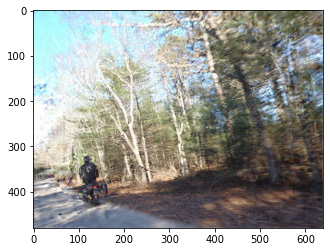

./coco_test/000000000552.jpg


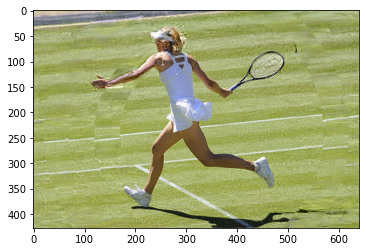

./coco_test/000000000205.jpg


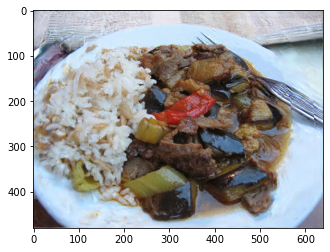

./coco_test/000000000139.jpg


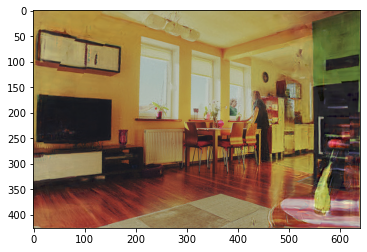

In [6]:
image_num_list =  [19,69,979,552,205,139]
for image_number in image_num_list:
    image_name = str(image_number).zfill(12)
    
    mongs = readin_mongrels(eccentricities, image_name, base_directory)
    psuedo_foveated_mongrel = create_psuedo_foveated_img(mongs)

    plt.imshow(psuedo_foveated_mongrel)
    plt.show()
    psuedo_foveated_mongrel = cv2.cvtColor(psuedo_foveated_mongrel, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'pseudo_foveated_{image_name}.png',psuedo_foveated_mongrel)